In [1]:
import sys
sys.path.append('F:\Cambridge\Project\MHMC-for-VAE\change_of_variable')
sys.path.append('F:\Cambridge\Project\MHMC-for-VAE\hmc_pytorch')
from change_of_variable_pytorch import * 
from hmc_base_pytorch import *
from hmc_unconstrained_pytorch import *
import numpy as np
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions.multivariate_normal import MultivariateNormal
from torch.distributions.normal import Normal
import matplotlib.pyplot as plt

import torch.utils.data
from torch import optim
from torchvision import datasets, transforms
from torchvision.utils import save_image
import time
import torchvision

In [2]:
#d = data.view(-1, 784)[j].view(1, 784)
x = torch.tensor([[1.,2.],[3.,4.]])
y = torch.tensor([[1.,2.],[3.,4.]])
#one_new_data = torch.cat((d.float(), zt), 1) # append data with zt
one_new_data = torch.cat((x, y), 1)

In [4]:
x

tensor([[ 1.,  2.],
        [ 3.,  4.]])

In [3]:
one_new_data

tensor([[ 1.,  2.,  1.,  2.],
        [ 3.,  4.,  3.,  4.]])

In [7]:
cuda = True
batch_size = 64
epochs = 10
seed = 1
log_interval = 10
z_dim = 20

device = torch.device("cuda" if cuda else "cpu")
kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}

train_data = datasets.MNIST('../data', train=True, download=True, transform=transforms.ToTensor())
test_data = datasets.MNIST('../data', train=False, transform=transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(
    train_data,
    batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    test_data,
    batch_size=batch_size, shuffle=True, **kwargs)



In [45]:
def binarization(data):
    #s = np.random.uniform(size = data.shape)
    s = 0.5*np.ones(shape = data.shape)
    out = np.array(s<data).astype(float)
    return out

In [46]:
result = []
for batch_idx, (data, _) in enumerate(train_loader):
    data = data.view(-1, 784).numpy()
    bi_data = binarization(data)
    d = torch.from_numpy(bi_data)
    result.append(d)
    #result.append(binarization(data))

In [47]:
train_data.train_data[0].numpy().shape
result[0][0].reshape(28,28).shape

torch.Size([28, 28])

torch.Size([60000, 28, 28])
torch.Size([60000])


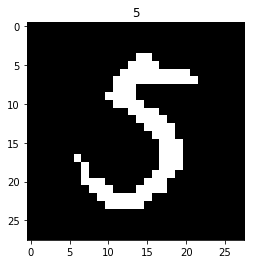

In [48]:
# plot one example
print(train_data.train_data.size())                 # (60000, 28, 28)
print(train_data.train_labels.size())               # (60000)
#plt.imshow(train_data.train_data[0].numpy(), cmap='gray')
plt.imshow(result[0][0].reshape(28,28), cmap='gray')
plt.title('%i' % train_data.train_labels[0])
plt.show()

In [11]:
def reparameterize(mu, logvar):
    std = torch.exp(0.5*logvar)
    eps = torch.randn_like(std)
    return eps.mul(std).add_(mu)

In [31]:
def log_prior(z):
    dim = z.shape[1]
    mean = torch.zeros(dim).cuda()
    cov = torch.eye(dim).cuda()
    m = MultivariateNormal(mean, cov)
    m.requires_grad=True
    return m.log_prob(z)

In [34]:
z = torch.tensor([[0.]]).cuda()
log_prior(z)

tensor([-0.9189], device='cuda:0')

In [4]:
def multivariate_normal_logpdf(mean, cov, x):
    mean = mean.cuda()
    cov = cov.cuda()
    k = x.shape[0]
    t1 = -0.5*(x - mean).view(1, k)@torch.inverse(cov)@(x - mean).view(k, 1)
    t2 = 0.5*k*torch.log(2*torch.tensor([math.pi]).cuda()) + 0.5*torch.log(torch.det(cov))
    return t1 - t2

In [5]:
def multivariate_normal_diagonal_logpdf(mean, cov_diag, x):
    mean = mean.cuda()
    cov_diag = cov_diag.cuda()
    n = x.shape[0] # number of samples
    k = x.shape[1] # dimension
    t1 = -0.5*(x - mean)*(1/cov_diag)*(x-mean)
    t1 = torch.sum(t1, dim=1)
    #t2 = 0.5*k*torch.log(2*torch.tensor([math.pi]).cuda()) + 0.5*torch.log(torch.prod(cov_diag,1)).cuda()
    t2 = 0.5*k*torch.log(2*torch.tensor([math.pi]).cuda()) + 0.5*torch.sum(torch.log(cov_diag)).cuda()
    return t1 - t2
    #return t1 - t2

In [10]:
mean = torch.tensor([[0.,0.,0.],[0.,0.,0.]]).cuda()
cov_diag = torch.tensor([[1.,1.,1.],[1.,1.,1.]]).cuda()
x = torch.tensor([[0.,0.,0.],[1.,1.,0.]]).cuda()
multivariate_normal_diagonal_logpdf(mean, cov_diag, x)

tensor([-2.7568, -3.7568], device='cuda:0')

In [15]:
mean = torch.tensor([0.,0.,0.]).cuda()
cov = torch.eye(3).cuda()
x = torch.tensor([0.,0.,0.]).cuda()
multivariate_normal_logpdf(mean, cov, x)-torch.tensor([1.]).cuda()

tensor([[-3.7568]], device='cuda:0')

In [16]:
mean = torch.tensor([0.,0.,0.]).cuda()
cov = torch.tensor([1.,1.,1.]).cuda()
x = torch.tensor([0.,0.,0.]).cuda()
multivariate_normal_diagonal_logpdf(mean, cov, x)

IndexError: tuple index out of range

In [16]:
log_prior(x)

tensor([-15.3818,  -3.7568], device='cuda:0')

In [193]:
mean = torch.tensor([0.,0.,0.]).cuda()
cov = torch.eye(3).cuda()
x = torch.tensor([1.,1.,0.]).cuda()
multivariate_normal_logpdf(mean, cov, x)

tensor([[-3.7568]], device='cuda:0')

In [136]:
cov_diag = torch.tensor([[1.,2.,1.],[1.,1.,1.],[4.,1.,1.]])
torch.prod(cov_diag,1)

tensor([ 2.,  1.,  4.])

In [100]:
x = torch.tensor([[1.,1.,1.],[2.,1.,0.]])
y = torch.tensor([[2.,0.,0.],[1.,1.,1.]])
x.shape

torch.Size([2, 3])

In [47]:
mean = torch.tensor([[[0.,0.,0.]],[[0.,1.,0.]],[[0.,0.,0.]]])
mean.shape
cov = torch.tensor([[[1.,0.,0.],[0.,1.,0.],[0.,0.,1.]],[[1.,0.,0.],[0.,1.,0.],[0.,0.,1.]],[[1.,0.,0.],[0.,1.,0.],[0.,0.,1.]]])
cov.shape
x = torch.tensor([[[0., 2.,0.]],[[0., 0.,0.]],[[0., 0.,0.]]])
mean.shape

torch.Size([3, 1, 3])

In [48]:
mean = torch.tensor([[[0.,0.]],[[0.,1.]],[[0.,0.]]])
mean.shape
cov = torch.tensor([[[1.,0.],[0.,1.]],[[1.,0.],[0.,1.]],[[1.,0.],[0.,1.]]])
cov.shape
x = torch.tensor([[[0., 2.]],[[0., 0.]],[[0., 0.]]])
mean.shape

torch.Size([3, 1, 2])

In [49]:
m = MultivariateNormal(mean, cov)
tt = m.log_prob(x)
tt

tensor([[-3.8379, -3.8379, -3.8379],
        [-2.3379, -2.3379, -2.3379],
        [-1.8379, -1.8379, -1.8379]])

In [50]:
mean = torch.tensor([[0., 0.,0.]])
#mean = torch.tensor([[0.],[0.]])
cov = torch.eye(3)
x = torch.tensor([0., 0., 0.])
m = MultivariateNormal(mean, cov)
print(m.log_prob(x))

tensor([-2.7568])


In [9]:
class decoder(nn.Module):
    def __init__(self):
        super(decoder, self).__init__()
        self.fc1 = nn.Linear(z_dim, 400)
        self.fc2 = nn.Linear(400, 784)
    # single hidden layer
    def forward(self, x):
        #x = x.view(-1, 784)
        h1 = F.relu(self.fc1(x))
        return F.sigmoid(self.fc2(h1))

In [10]:
class q_z0(nn.Module):
    def __init__(self):
        super(q_z0, self).__init__()
        self.fc1 = nn.Linear(784, 300)
        #self.fc2 = nn.Linear(300, 300)
        self.fc31 = nn.Linear(300, z_dim)
        self.fc32 = nn.Linear(300, z_dim)
    def forward(self, x):
        x = x.view(-1, 784)
        h1 = F.relu(self.fc1(x))
        #h2 = F.relu(self.fc2(h1))
        logvar = self.fc31(h1)
        mu = self.fc32(h1)
        return mu, logvar
    

In [11]:
class r_v(nn.Module):
    def __init__(self):
        super(r_v, self).__init__()
        self.fc1 = nn.Linear(z_dim + 784, 300)
        self.fc21 = nn.Linear(300, z_dim)
        self.fc22 = nn.Linear(300, z_dim)
    def forward(self, x):
        x = x.view(-1, 784 + z_dim)
        h1 = F.softplus(self.fc1(x))
        logvar = self.fc21(h1)
        mu = self.fc22(h1)
        return mu, logvar

In [12]:
class q_v(nn.Module):
    def __init__(self):
        super(q_v, self).__init__()
        self.fc1 = nn.Linear(784, 300)
        # no need to output mu because the mean of momentum is default 0
        self.fc21 = nn.Linear(300, z_dim)
    def forward(self, x):
        x = x.view(-1, 784)
        h1 = F.softplus(self.fc1(x))
        logvar = self.fc21(h1)
        return logvar

In [13]:
mean = torch.zeros(2,1)
cov = torch.eye(2)
m = MultivariateNormal(mean, cov)
x = torch.tensor([0.,0.]) 
m.log_prob(x)

tensor([-0.9189, -0.9189])

In [14]:
decoder = decoder().to(device)
q_z0 = q_z0().to(device)
r_v = r_v().to(device)
q_v = q_v().to(device)
log_mass_diag = torch.randn(z_dim, requires_grad=True)
#mass = torch.randn(z_dim, requires_grad=True)
#mass = torch.eye(z_dim, requires_grad=True)
#mass_cuda = mass.cuda()

In [17]:
def lower_bound(decoder, q_z0, r_v, data, log_mass_diag, T):
    batch_size = data.view(-1, 784).shape[0]
    data = data.to(device)
    
    #mu_z0 = q_z0_mean.repeat(batch_size,1).cuda()
    #logvar_z0 = q_z0_logvar.repeat(batch_size,1).cuda()
    
    
    mu_z0, logvar_z0 = q_z0(data)
    var_z0 = torch.exp(logvar_z0)
    print("mu_z0: "+str(mu_z0.shape))
    #print(logvar_z0.shape)

    # sample z0
    z0 = reparameterize(mu_z0, logvar_z0)
    print("z0: " + str(z0.shape))
    #print(z0)

    # get joint probaility p(x, z0)
    log_prior_z0 = log_prior(z0)
    #print("log_prior_z0: " + str(log_prior_z0.shape))
    decoder_output = decoder(z0)
    #print("decoder_output: " + str(decoder_output.shape))
    log_likelihood = 0. - F.binary_cross_entropy(decoder_output, data.view(-1, 784).float(), size_average=False, reduce=False)
    #print("log_likelihood: " + str(log_likelihood.shape))
    log_likelihood = torch.sum(log_likelihood, dim = 1)
    #print("log_likelihood: " + str(log_likelihood.shape))
    log_joint = log_prior_z0 + log_likelihood
    #print("log_joint: " + str(log_joint.shape))

    # get log q_z0
    log_q_z0 = multivariate_normal_diagonal_logpdf(mu_z0, var_z0, z0)

    # initial L for 128 samples
    L = log_joint - log_q_z0.view(batch_size)
    L = torch.sum(L)
    #print("L "+str(L))
    #print(L.shape)

    #print("====================================")
    for i in range(T):
        # sample v1
        mass_diag = torch.exp(log_mass_diag)
        mass_matrix = torch.diag(mass_diag)
        mass_matrix.cuda()
        print(log_mass_diag)
        
        #var_v1_matrix = torch.inverse(mass_matrix)
        #var_v1_diag = torch.diag(var_v1_matrix)
        #logvar_v1_diag = torch.log(var_v1_diag)
        
        
        logvar_v1_diag = -log_mass_diag
        var_v1_diag = torch.exp(logvar_v1_diag)
        
        
        
        logvar_v1 = logvar_v1_diag.repeat(batch_size,1).cuda()
        var_v1 = var_v1_diag.repeat(batch_size,1).cuda()
        mu_v1 = torch.zeros(logvar_v1.shape[0], logvar_v1.shape[1]).cuda()
        v1 = reparameterize(mu_v1, logvar_v1)
        #print(v1)
        
        # get q_v1
        
        log_q_v1 = multivariate_normal_diagonal_logpdf(mu_v1, var_v1 ,v1)
        

        log_joint_t = torch.zeros(0).cuda() # list of all the joint
        log_r_vt = torch.zeros(0).cuda()
        alpha = torch.tensor([0.]).cuda() # lower bound for each batch (128 samples)
        for j in range(batch_size):
            def energy_function(z, cache):
                z.retain_grad()
                z = z.view(1, z.shape[0])
                z = z.cuda()
                one_log_prior = log_prior(z)
                decoder_output = decoder(z)
                one_log_likelihood = 0. - F.binary_cross_entropy(decoder_output, data.view(-1, 784)[j].float(), size_average=False, reduce=False)
                #print(one_log_likelihood.shape)
                one_log_likelihood = torch.sum(one_log_likelihood, dim = 1)
                one_log_joint = one_log_prior + one_log_likelihood
                return 0 - one_log_joint
            sampler = IsotropicHmcSampler(energy_function, energy_grad=None, prng=None,
                                          mom_resample_coeff=1., dtype=np.float64)
            init = torch.zeros(z_dim).cuda()
            
            pos_samples, mom_samples, ratio = sampler.get_samples(init, 0.1, 3, 2, mass_matrix, mom = v1[j].view(z_dim))
            #print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~`")
            #print(pos_samples[1].shape)

            # get joint probaility p(x, zt)
            zt = pos_samples[1].cuda()
            vt = mom_samples[1].cuda()
            zt = zt.view(1, zt.shape[0])
            vt = vt.view(vt.shape[0])

            # get joint probaility p(x, zt)
            one_log_prior_zt = log_prior(zt)
            #print("one_log_prior_zt: " + str(one_log_prior_zt.shape))
            one_decoder_output_t = decoder(zt)
            #print("one_decoder_output_t: " + str(one_decoder_output_t.shape))
            one_log_likelihood_t = 0. - F.binary_cross_entropy(one_decoder_output_t, data.view(-1, 784)[j].float(), size_average=False, reduce=False)
            one_log_likelihood_t = torch.sum(one_log_likelihood_t, dim = 1)
            #print("one_log_likelihood_t: " + str(one_log_likelihood_t.shape))
            one_log_joint_t = one_log_prior_zt + one_log_likelihood_t
            #print("one_log_joint_t: " + str(one_log_joint_t.shape))
            log_joint_t = torch.cat((log_joint_t, one_log_joint_t), 0)

            # get r_vt
            d = data.view(-1, 784)[j].view(1, 784)
            one_new_data = torch.cat((d.float(), zt), 1) # append data with zt
            one_mu_vt, one_logvar_vt = r_v(one_new_data)
            one_var_vt = torch.exp(one_logvar_vt)
            one_mu_vt = one_mu_vt.view(one_mu_vt.shape[1])
            one_cov = torch.diag(one_var_vt.view(one_var_vt.shape[1]))
            #m = MultivariateNormal(one_mu_vt, one_cov)
            #one_log_r_vt = m.log_prob(vt).view(1)
            one_log_r_vt = multivariate_normal_logpdf(one_mu_vt, one_cov, vt)
            log_r_vt = torch.cat((log_r_vt, one_log_r_vt), 0)
            

            # get L for each sample
            one_log_alpha = log_joint_t[j] + log_r_vt[j] - log_joint[j] - log_q_v1[j]
            #print("one log alpha: "+str(one_log_alpha))
            #one_log_alpha = torch.log(one_alpha)
            L = L + one_log_alpha
            #alpha = alpha + one_alpha
        #L = L + torch.log(alpha)

    #print("~~~~~~~~~~~~~~~~~~~ new L " + str(L) + " ~~~~~~~~~~~~~~~~~~~")
    return L/batch_size    
                

In [25]:
list(q_z0.parameters())
log_mass_diag

tensor([nan., nan., nan., nan., nan., nan., nan., nan., nan., nan.,
        nan., nan., nan., nan., nan., nan., nan., nan., nan., nan.])

In [18]:
params1 = list(decoder.parameters())+list(r_v.parameters())

optimizer1 = optim.Adam(params1, lr=0.0001, weight_decay=1e-5)
optimizer2 = optim.Adam([log_mass_diag], lr=0.0001)
optimizer3 = optim.Adam(q_z0.parameters(), lr=0.0001, weight_decay=1e-4)
nn.utils.clip_grad_norm_(q_z0.parameters(), 50)

for i in range(len(result)):
    print("++++++++++ " + str(i) + " ++++++++++")
    
    data = result[i].float()
    optimizer1.zero_grad()
    optimizer2.zero_grad()
    optimizer3.zero_grad()
    L = lower_bound(decoder, q_z0, r_v, data, log_mass_diag, 1)
    loss = 0. - L
    loss.backward()
    #print('weight grad after backward')
    #print(net.conv1.bias.grad)
    #print(q_z0.fc1.weight.grad)
    #print(q_z0.fc31.weight.grad)
    #print(q_z0.fc32.weight.grad)
    optimizer1.step()
    optimizer2.step()
    optimizer3.step()
    print(L.item())
print(L.item())


++++++++++ 0 ++++++++++
mu_z0: torch.Size([64, 20])
z0: torch.Size([64, 20])
tensor([-2.6590,  0.6581, -0.5448,  1.5155, -0.7538, -0.5816, -0.7492,
        -1.2490,  0.1221, -1.2655,  0.8417,  1.1234, -0.1018,  0.7371,
         0.4650,  1.1652,  1.5014,  1.1545,  1.3702, -1.3800])


D:\Anaconda3\lib\site-packages\torch\nn\functional.py:1474: UserWarning: Using a target size (torch.Size([784])) that is different to the input size (torch.Size([1, 784])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


KeyboardInterrupt: 

In [219]:
params1 = list(decoder.parameters())+list(q_z0.parameters())+list(r_v.parameters())
optimizer1 = optim.Adam(params1, lr=0.0003)
optimizer2 = optim.Adam([log_mass_diag, q_z0_mean, q_z0_logvar], lr=0.0003)
nn.utils.clip_grad_norm_(q_z0.parameters(), 50)
for batch_idx, (data, _) in enumerate(train_loader):
    print("++++++++++ " + str(batch_idx) + " ++++++++++")
    
    optimizer1.zero_grad()
    optimizer2.zero_grad()
    L = lower_bound(decoder, q_z0_mean, q_z0_logvar, r_v, data, log_mass_diag, 1)
    loss = 0. - L
    loss.backward()
    #print('weight grad after backward')
    #print(net.conv1.bias.grad)
    #print(q_z0.fc1.weight.grad)
    #print(q_z0.fc31.weight.grad)
    #print(q_z0.fc32.weight.grad)
    optimizer1.step()
    optimizer2.step()
    print(L.item())
print(L.item())

++++++++++ 0 ++++++++++
torch.Size([64, 20])
torch.Size([64, 20])


D:\Anaconda3\lib\site-packages\torch\nn\functional.py:1474: UserWarning: Using a target size (torch.Size([784])) that is different to the input size (torch.Size([1, 784])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


-540.8672485351562
++++++++++ 1 ++++++++++
torch.Size([64, 20])
torch.Size([64, 20])
-572.6387939453125
++++++++++ 2 ++++++++++
torch.Size([64, 20])
torch.Size([64, 20])
-588.7979125976562
++++++++++ 3 ++++++++++
torch.Size([64, 20])
torch.Size([64, 20])
-579.67236328125
++++++++++ 4 ++++++++++
torch.Size([64, 20])
torch.Size([64, 20])
-559.671142578125
++++++++++ 5 ++++++++++
torch.Size([64, 20])
torch.Size([64, 20])
-544.0812377929688
++++++++++ 6 ++++++++++
torch.Size([64, 20])
torch.Size([64, 20])
-544.778076171875
++++++++++ 7 ++++++++++
torch.Size([64, 20])
torch.Size([64, 20])
-516.0226440429688
++++++++++ 8 ++++++++++
torch.Size([64, 20])
torch.Size([64, 20])
-505.8245544433594
++++++++++ 9 ++++++++++
torch.Size([64, 20])
torch.Size([64, 20])
-497.9623107910156
++++++++++ 10 ++++++++++
torch.Size([64, 20])
torch.Size([64, 20])
-487.72406005859375
++++++++++ 11 ++++++++++
torch.Size([64, 20])
torch.Size([64, 20])
-463.9438781738281
++++++++++ 12 ++++++++++
torch.Size([64, 20])
t

KeyboardInterrupt: 

In [ ]:
L

In [37]:
#params = mass_diag


#optimizer = optim.Adam(params, lr=1e-3)

w = torch.randn([3,5], requires_grad=True)
b = torch.randn(3, requires_grad=True)
#x = Variable(torch.randn(5))

optimizer = optim.SGD([w], lr=0.01)

TypeError: params argument given to the optimizer should be an iterable of Tensors or dicts, but got torch.FloatTensor

In [21]:
list(decoder.parameters())
params[0].shape

torch.Size([400, 20])

In [25]:
list(decoder.parameters())[0]
#list(mass_diag)[0]
mass_diag.is_cuda

False

In [78]:
tt = torch.ones(1, 784).cuda()
print(tt.shape)
torch.sum(tt, dim=1)
tt.is_cuda

torch.Size([1, 784])


True

In [ ]:
x = torch.tensor([[0.1, 0.1],[0.1,0.1],[0.1,0.1]])
y = torch.tensor([[0.5, 0.5],[0.5,0.5],[1.,1.]])
L = F.binary_cross_entropy(y, x, size_average=False, reduce=False)
L

In [17]:
x = torch.tensor([[0.1, 0.1],[0.1,0.1]])
torch.inverse(x)

RuntimeError: Lapack Error getrf : U(2,2) is 0, U is singular at c:\programdata\miniconda3\conda-bld\pytorch_1524546354046\work\aten\src\th\generic/THTensorLapack.c:514